In [28]:
import numpy as np
import random

import matplotlib.pyplot as plt



In [127]:
class Environment:
    def __init__(self, size = 5):
        self.size = size
        self.goodState1 = [0,1]
        self.goodState2 = [0,3]
        self.goodStates = [self.goodState1,self.goodState2]
        self.toState1 = [4,1]
        self.toState2 = [2,3]
        self.toStates = [self.toState1,self.toState2]
        self.badState1 = [1,1]
        self.badState2 = [4,4]
        self.badStates = [self.badState1,self.badState2]
        

        
    
    # action "right","left","up","down"
    def step(self, state: list, action: str) -> (list,str):
        reward = 0
        
        # Calculate a new "theoretical" state
        new_state = [sum(x) for x in zip(state,self.getDirectionVector(action))]
        # Check if we are in a good state
        if (state in self.goodStates):
            if state == self.goodState1:
                reward = 10
                new_state = self.toState1
            else:
                reward = 5
                new_state = self.toState2
        # Check if new "theoretical" state is actually a valid state
        elif any(coordinate not in range(0,self.size) for coordinate in new_state):
            # new state is actually illegal
            reward = -1
            new_state = state    
        # Check if we are in a bad state
        elif (state in self.badStates):
            reward = -1
        return new_state,reward
            
        
    # a mapping of directions to vectors     
    def getDirectionVector(self,direction) -> list:
        directionVector = [0,0]
        if direction == "left":
            directionVector = [0,-1]
        elif direction == "right":
            directionVector = [0,1]
        elif direction == "down":
            directionVector = [1,0]
        elif direction == "up":
            directionVector = [-1,0]
            
        return directionVector       

        


In [128]:
def policy(state: list, action: str) -> float:
    return 0.25

In [129]:
env = Environment()
actions = ["left","right","up","down"]
numberOfStates = env.size * env.size
numberOfActions = len(actions)
R = np.zeros((numberOfStates,numberOfStates))
P = np.zeros((numberOfStates,numberOfStates))

for y in range(env.size):
    for x in range(env.size):
        state = [y,x]
        for action in actions:
            next_state, immediate_reward = env.step(state,action)
            y_next,x_next = next_state
            R[y*env.size + x][x_next*env.size + y_next] = immediate_reward
            P[y*env.size + x][x_next*env.size + y_next] += policy(state,action)
            
R_e = np.sum(P*R, axis=1, keepdims=True)


# solves equation Ax = B
# (I - yP)V = R_e
gamma = 0.9
A=np.eye(25) - gamma*P
B=R_e
V=np.linalg.solve(A,B)
V = np.reshape(V,(env.size,env.size))


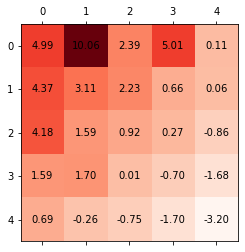

In [130]:
def vis_matrix(M, cmap=plt.cm.Reds):
    fig, ax = plt.subplots()
    ax.matshow(M, cmap=cmap)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            c = M[j, i]
            ax.text(i,j, "%.2f" % c, ha='center', va='center')
    
vis_matrix(V)

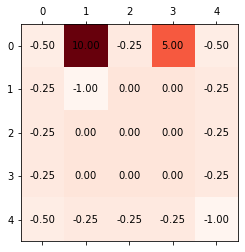

In [131]:
# solves equation Ax = B
# (I - yP)V = R_e
gamma = 0.0
A=np.eye(25) - gamma*P
B=R_e
V=np.linalg.solve(A,B)
V = np.reshape(V,(env.size,env.size))
vis_matrix(V)